# Statistical Data Analysis Based on the GoFast Scooter Rental Service  

We have received data on some GoFast service users from various cities, as well as information about their rides. We need to analyze the data and test some hypotheses that may help the business grow.  
To travel around the city, GoFast users use a mobile app. The service can be used as follows:  
- without a subscription  
  - no subscription fee;  
  - cost per minute of a ride — 88 rubles;  
  - start ride cost — 5050 rubles;  
- with an Ultra subscription  
  - subscription fee — 199199 rubles per month;  
  - cost per minute of a ride — 66 rubles;  
  - start ride cost — free.


In [1]:
# import libraries in a single block at the start of the project  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import binom
import scipy.stats as stats

In [2]:
# import data and immediately convert date type to datetime64  
try:
    data_rides = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_4_Samokaty/rides_go.csv',parse_dates=['date'], dayfirst=True)
    data_users = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_4_Samokaty/users_go.csv')
    data_subscriptions = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_4_Samokaty/subscriptions_go.csv')

except:
    data_rides = pd.read_csv('/datasets/rides_go.csv',parse_dates=['date'], dayfirst=True)
    data_users = pd.read_csv('/datasets/users_go.csv')
    data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
    
# display information on structure and data for each dataframe
def get_info(dataset):
        dataset.info(), 
        return dataset.head(10)
        

display(get_info(data_rides),
        get_info(data_users),
        get_info(data_subscriptions))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Col

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Conclusion**  

A preliminary assessment of the loaded data suggests completeness (no obvious missing values were found). Among the evident adjustments, we need to convert the date to the appropriate type in one of the tables, and merging tables for ease of analysis seems appropriate (especially since there are common columns for merging - `user_id` and `subscription_type`). It will also be necessary to check the data for duplicates, implicit missing values, and anomalous values.

## Предобработка данных

In [3]:
# create a new column with the month number based on the date column
data_rides['date'] = pd.to_datetime(data_rides['date'])

data_rides['month_ride'] = data_rides['date'].dt.month

# check the two main dataframes for missing values
display(data_rides.isna().sum())
data_users.isna().sum()

user_id       0
distance      0
duration      0
date          0
month_ride    0
dtype: int64

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [4]:
# convert text columns to lowercase and check the main dataframes for explicit duplicates
data_users['name'] = data_users['name'].str.lower()
data_users['city'] = data_users['city'].str.lower()
data_users['subscription_type'] = data_users['subscription_type'].str.lower()

display(data_rides.duplicated().sum())
display(data_users.duplicated().sum())

0

31

In [5]:
# remove explicit duplicates  
data_users = data_users.drop_duplicates()

In [6]:
# check the time period over which the ride data was collected
display(f'Start of the period: {data_rides["date"].max()}') 
display(f'End of the period: {data_rides["date"].min()}')

display(f'Duration in days: {data_rides["date"].max() - data_rides["date"].min()}')

'Начало периода: 2021-12-30 00:00:00'

'Конец периода: 2021-01-01 00:00:00'

'Срок в днях: 363 days 00:00:00'

**Conclusion**  

During preprocessing, we converted the date data to the correct type and created a separate column for the month of the ride for further analysis. Mo missing values were found, explicit duplicates in the user data dataframe were identified and removed, and the data were collected over the year 2021.  

## Exploratory Data Analysis

Let's analyze the data by user cities:  

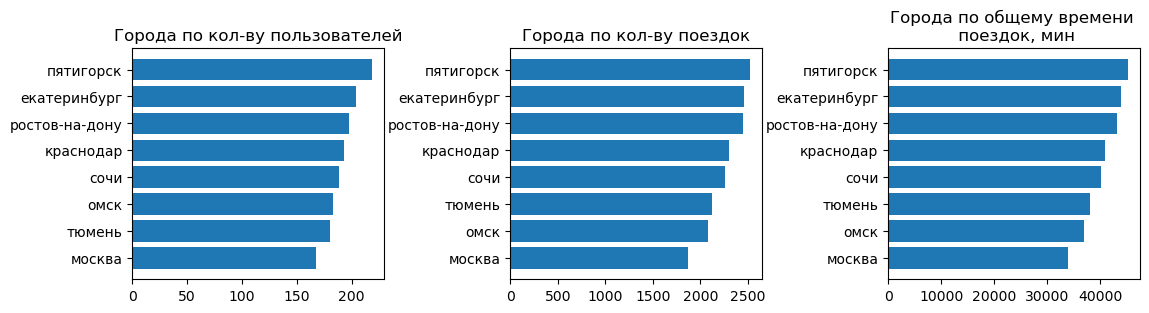

In [7]:
# plot the number of users by city
plt.figure(figsize=[13, 3])
plt.subplots_adjust(wspace=0.5, hspace=0.1)

plt.subplot(1,3,1)
plt.barh(data_users['city'].value_counts(ascending=True).index,data_users['city'].value_counts(ascending=True));
plt.title('Cities by number of users');

# plot the service usage by cities (by number of rides and total ride duration)
cities = data_users['city'].unique()
cities_df = cities_df1 = pd.DataFrame() #dataframes for collecting data between the two main dataframes  

for city in cities:
    
    cities_df = data_users[data_users['city'] == city]
    cities_df = cities_df.reset_index(drop=True)
    cities_df1.loc[city,0]= data_rides.query('user_id in @cities_df.user_id')['user_id'].count()
    cities_df1.loc[city,1]= data_rides.query('user_id in @cities_df.user_id')['duration'].sum()
   
cities_df1 = cities_df1.sort_values(by=0,ascending=True)
plt.subplot(1,3,2)
plt.barh(cities_df1.index,cities_df1[0]); 
plt.title('Cities by number of rides');

cities_df1 = cities_df1.sort_values(by=1,ascending=True)
plt.subplot(1,3,3)
plt.barh(cities_df1.index,cities_df1[1]);
plt.title('Cities by total ride \n duration, min.');


Calculate the ratio of users with a subscription to those without a subscription and plot a graph:

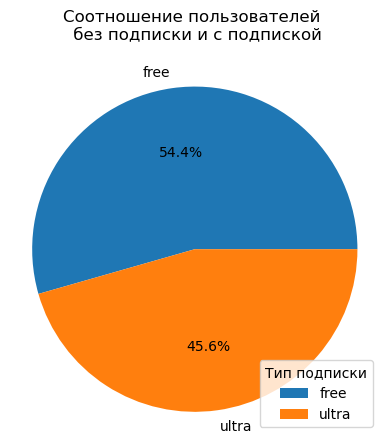

In [8]:
groupby = data_users.groupby('subscription_type')['user_id'].agg('count');

groupby.plot(kind='pie', 
             title ="Ratio of users without a subscription \n to those with a subscription\n",
             radius=1.1,
             ylabel='',
             autopct='%1.1F%%');
plt.legend(title="Type of subscription", loc="best");


Examine the distribution of users by age:

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Межквартильный размах по возрасту пользователей: 6 лет


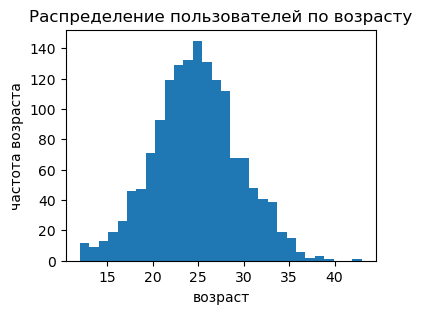

In [9]:
# view general information on age data
display(data_users['age'].describe());

# plot the histogram
data_users['age'].plot(kind='hist', 
                       bins=30, 
                       title ="User age distribution",
                       figsize=(4,3))
plt.xlabel('age')
plt.ylabel('age frequency');

# calculate the interquartile range (evident from the output of the describe method above)
print(f'Interquartile range of user age : {round(data_users["age"].quantile(0.75) - data_users["age"].quantile(0.25))} years')


Examine distance data and calculate the distance traveled by a user per ride:  

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

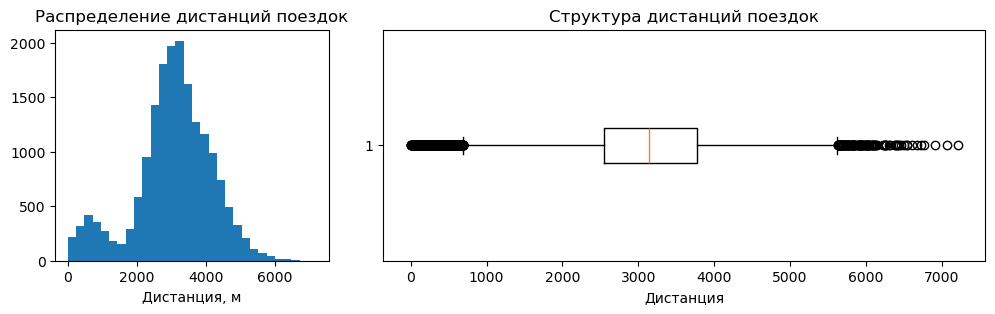

Среднее расстояние за одну поездку составило: 3071м
Межквартильный размах по дистанции поездок составил:1233


In [10]:
# view general information on age data
display(data_rides['distance'].describe());

# plot a histogram and boxplot of ride data  
plt.figure(figsize=[12, 3])

plt.subplot(1,3,1)
plt.hist(data_rides['distance'], bins=30);
plt.xlabel('Distance, м')
plt.title('Distribution of ride distances');

plt.subplot(1,3,(2,3))
plt.boxplot(data_rides['distance'],vert=False);
plt.xlabel('Distance')
plt.title('Structure of ride distances');

plt.show();

# calculate the average distance per ride 
print(f'The average distance per ride was: {round(data_rides["distance"].sum()/len(data_rides["distance"]))}м')
# calculate the interquartile range (evident from the output of the describe method above)
print(f'The interquartile range of ride distances was: {round(data_rides["distance"].quantile(0.75) - data_rides["distance"].quantile(0.25))}') 

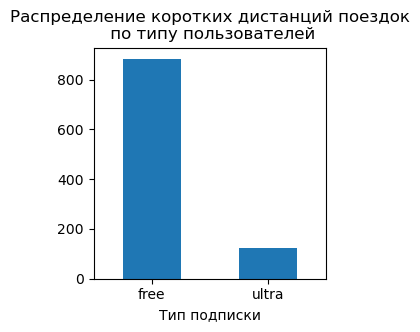

In [11]:
# examine which users contributed to the "peak" of short ride lengths around 750m
rides_short = data_rides[data_rides['distance']<750]
# add user data
rides_short = rides_short.merge(data_users, on='user_id', how='left')

rides_short.groupby('subscription_type')['subscription_type'].count().plot(kind='bar', figsize=(3,3))
plt.xlabel('Type of subscription')
plt.title('Distribution of short ride \n distances by user type')
plt.xticks(rotation=0);

There were no critical remarks regarding the ride distance data. The data shows two peaks at 720 meters (short rides) and 3100 meters (long rides). The overwhelming majority of short rides were taken by users with the free tariff. The presence of two peaks can be explained by two main patterns of user behavior: a short ride from a public transport station to home (and back) and a complete ride directly to the destination, or a leisurely ride.

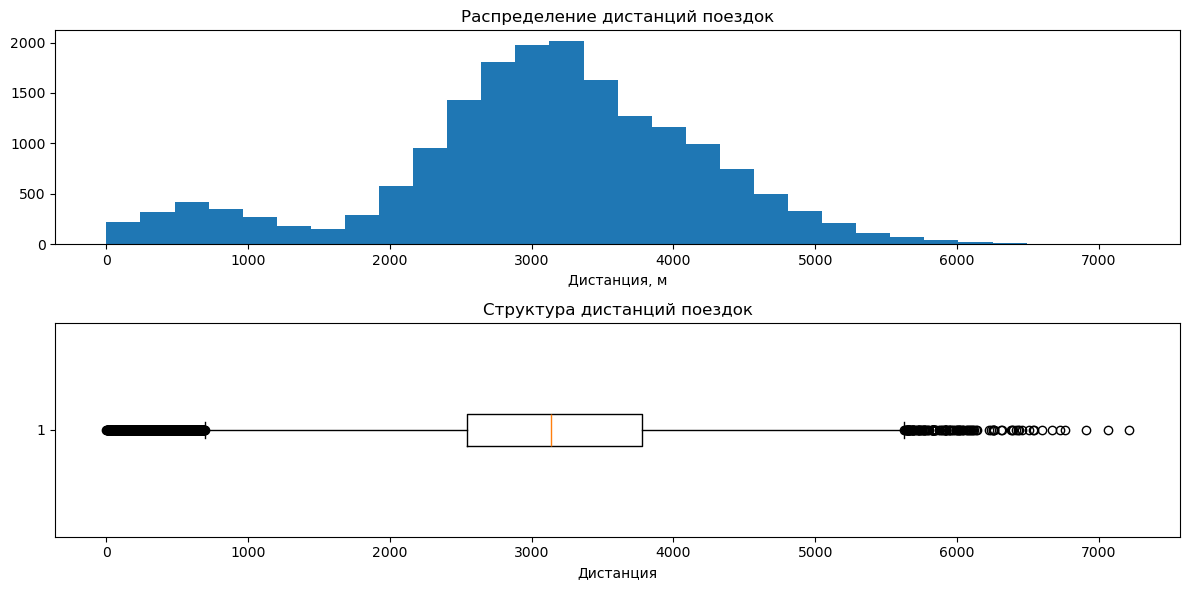

In [12]:
# plot a histogram and boxplot of ride data
plt.figure(figsize=[12, 6])

plt.subplot(2,1,1)
plt.hist(data_rides['distance'], bins=30);
plt.xlabel('Distance, m')
plt.title('Distribution of ride distances');

plt.subplot(2,1,2 )
plt.boxplot(data_rides['distance'],vert=False);
plt.xlabel('Distance')
plt.title('Structure of ride distances');

# set boundaries for the plots to avoid overlapping
plt.tight_layout()

plt.show();

Examine the ride duration data:

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

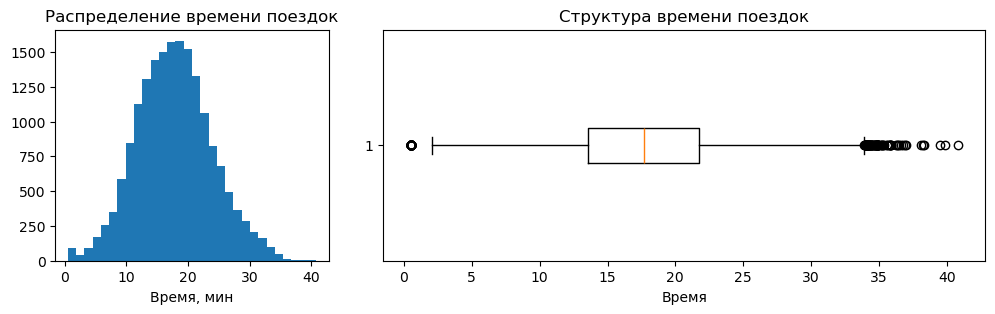

Средняя продолжительность поездок составила: 18 мин.
Межквартильный размах по продолжительности поездок составил:8


In [13]:
# view general information on ride data
display(data_rides['duration'].describe());

# plot a histogram and boxplot of ride duration data
plt.figure(figsize=[12, 3])

plt.subplot(1,3,1)
plt.hist(data_rides['duration'], bins=30);
plt.xlabel('Duration, min')
plt.title('Distribution of ride durations');

plt.subplot(1,3,(2,3))
plt.boxplot(data_rides['duration'],vert=False);
plt.xlabel('Duration')
plt.title('Structure of ride durations');

plt.show();

# calculate the average duration of rides
print(f'The average duration of rides was: {round(data_rides["duration"].sum()/len(data_rides["duration"]))} min.')
# calculate the interquartile range (evident from the output of the describe method above)
print(f'The interquartile range of ride durations was: {round(data_rides["duration"].quantile(0.75) - data_rides["duration"].quantile(0.25))}') 


Both graphs show a small peak around zero values; let's calculate this outlier:

In [14]:
print('Number of rides shorter than 1 minute: ',data_rides[data_rides['duration'] < 1]['duration'].count())

# display the 5 extreme values in the table of near-zero rides
display(data_rides[data_rides['duration'] < 1].head(5))
display(data_rides[data_rides['duration'] < 1].tail(5))

Количество поездок короче 1 минуты:  95


,user_id,distance,duration,date,month_ride
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2


,user_id,distance,duration,date,month_ride
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2
17909,1524,4103.998874,0.5,2021-06-18,6


**Conclusion**  

Based on the analyzed data, we can conclude that there is a fairly uniform distribution of data across all the considered parameters.  
We also calculated that the average ride was 3071m and took 18 minutes, with the number of users without a subscription exceeding those with a subscription by approximately 15%. Regarding ride lengths, there are two peaks—at 720m and 3000m—which may be due to two usage patterns: short rides between home and the public transport station, as well as longer rides to destinations or leisurely trips.  

For ride duration, we identified a peak of ultra-short rides at half a minute, possibly indicating that all erroneously initiated and stopped rides are rounded to this time. It would be advisable to consult with colleagues who generate the datasets and, if confirmed that such short rides are erroneous, to exclude them from the dataset.  

The interquartile range for the respective parameters was:  
- for age - 6 years;  
- for ride duration - 8 minutes;  
- for ride distance - 1233 meters.

## Merging Data

As previously suggested, we will merge the three initial dataframes for easier analysis and access to data based on the key columns ‘user_id’ and ‘subscription_type:

In [15]:
# to verify the results of the merge later, we will record the dimensions of the original table with trip data
print(f'Original trip table dimensions: {data_rides.shape}')

# create a new combined DataFrame data
data = data_rides.merge(data_users, on='user_id', how='left')

# join the data from the third DataFrame containing subscription data
data = data.merge(data_subscriptions, on='subscription_type', how='left')

# check the dimensions after merging the tables
print(f'The merged table has a dimension of: {data.shape}')

# check the number of duplicates and missing values after merging
print(f'Number of duplicates in the new table: {data.duplicated().sum()}')
print(f'Number of missing values:\n{data.isna().sum()}')

# and display the first 10 rows of the new DataFrame
display(data.head(10))


Таблица поездок исходной размерностью: (18068, 5)
Объединенная таблица размерностью: (18068, 12)
Количество дубликатов в новой таблице: 0
Количество пропусков:
user_id              0
distance             0
duration             0
date                 0
month_ride           0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


,user_id,distance,duration,date,month_ride,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,кира,22,тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,кира,22,тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,кира,22,тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,кира,22,тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,кира,22,тюмень,ultra,6,0,199
5,1,2770.890808,16.650138,2021-10-09,10,кира,22,тюмень,ultra,6,0,199
6,1,3039.020292,14.927879,2021-10-19,10,кира,22,тюмень,ultra,6,0,199
7,1,2842.118050,23.117468,2021-11-06,11,кира,22,тюмень,ultra,6,0,199
8,1,3412.690668,15.238072,2021-11-14,11,кира,22,тюмень,ultra,6,0,199
9,1,748.690645,15.041884,2021-11-22,11,кира,22,тюмень,ultra,6,0,199


**Conclusion**

We sequentially combined the main table with trip data with user and subscription data, resulting in a unified table with the appropriate dimensions—18,068 trip records with 12 parameters for each trip.  
After the merge, there were no duplicates or missing values.

Let’s extract data from the new DataFrame, breaking it down by users with and without subscriptions:

In [16]:
# создадим датафрейм с данными по пользователям с подпиской
data_ultra = data[data['subscription_type'] == 'ultra']
# create a dataframe with data on users without a subscription
data_free = data[data['subscription_type'] == 'free']

# check the dimensions after splitting the tables
print(f'The combined table dimensions are: {data.shape}')
print(f'The table with paid subscribers dimensions are: {data_ultra.shape}')
print(f'The table with free subscribers dimensions are: {data_free.shape}')

Объединенная таблица размерностью: (18068, 12)
Таблица с платными подписчиками размерностью: (6500, 12)
Таблица с бесплатными подписчиками размерностью: (11568, 12)


Let's consider the information about the distance and duration of trips for users of both categories.

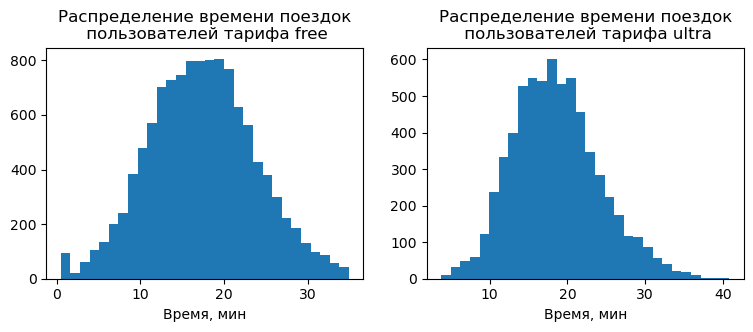

In [17]:
# plot the distribution of trip duration broken down by users with free and paid subscriptions
plt.figure(figsize=[9, 3])

plt.subplot(1,2,1)
plt.hist(data_free['duration'], bins=30);
plt.xlabel('Duration, min')
plt.title('Distribution of trip duration\n for free subscription users');

plt.subplot(1,2,2)
plt.hist(data_ultra['duration'], bins=30);
plt.xlabel('Duration, min')
plt.title('distribution of trip duration\n for ultra subscription users');

plt.show();

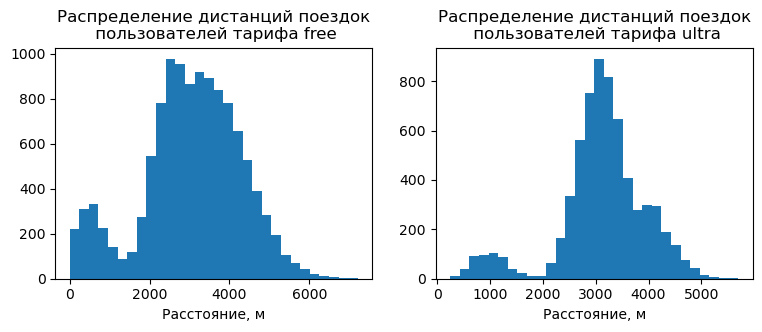

In [18]:
# let's build graphs of trip duration and distance distribution for ultra subscription users
plt.figure(figsize=[9, 3])

plt.subplot(1,2,1)
plt.hist(data_free['distance'], bins=30);
plt.xlabel('Distance, m')
plt.title('Distribution of trip distances\n for free subscription users');

plt.subplot(1,2,2)
plt.hist(data_ultra['distance'], bins=30);
plt.xlabel('Distance, m')
plt.title('Distribution of trip distances\n for ultra subscription users');

plt.show();

In [19]:
# look at the ratio of the number of trips for users on paid and free tariffs
print(f'The ratio of users on the paid tariff to those on the free tariff is: {len(data_ultra) / len(data_free):.2%}')

# and compare the statistics of both subsets
print('Comparison of statistics for numerical data between two types of users:')
print('on the ultra tariff:') 
display(data_ultra[["distance","duration","age"]].describe())
print('on the free tariff:')
display(data_free[["distance","duration","age"]].describe())

Соотношение пользователей на платном тарифе к числу на бесплатном тарифе равно: 56.19%
Сравнение статистик по числовых данных двух типов пользователей:
На тарифе ultra


,distance,duration,age
count,6500.000000,6500.000000,6500.000000
mean,3115.445388,18.541985,24.892615
std,836.895330,5.572048,4.757208
min,244.210438,3.760353,12.000000
25%,2785.444017,14.524654,22.000000
50%,3148.637229,18.178153,25.000000
75%,3560.574425,21.884129,28.000000
max,5699.769662,40.823963,38.000000


На тарифе free


,distance,duration,age
count,11568.000000,11568.000000,11568.000000
mean,3045.495282,17.390909,24.893326
std,1246.173806,6.326803,4.481100
min,0.855683,0.500000,12.000000
25%,2366.562689,12.958437,22.000000
50%,3114.648465,17.326890,25.000000
75%,3905.697894,21.594071,28.000000
max,7211.007745,34.948498,43.000000


**Conclusion**

As a result of merging the data frames, we obtained a single table with data on all users, their trips, and the cost of these trips (taking into account the applicable tariffs for each user). Based on the graphs of trip duration and distance for users on paid and free tariffs, we can conclude that the distribution structure of these data is very similar. Paid users made almost twice as few trips (56%) compared to free users. 

For short trips, there is a slight outlier among users on the free tariff, which we previously identified during the analysis of trip durations (ultra-short trips lasting less than 1 minute).

When comparing the statistics of the two samples, we can conclude that the average trip distances and durations for the two groups of users are slightly different (3115 m for paid users compared to 3045 m for free users and 19 minutes compared to 18 minutes, respectively). However, the average revenue from paid users is significantly higher (313 rubles compared to 193 rubles).

## Revenue calculation

For revenue calculation, we will first create and prepare a dataframe with aggregated trip data based on the merged dataframe.

In [20]:
# create a new dataframe and add columns with total distance, number of trips
# and total time for each user for each month
data_revenue = pd.DataFrame(columns = ['rides_distance_sum','rides_count','rides_duration_sum'])
data_revenue['rides_distance_sum'] = data.groupby(['user_id','month_ride'])['distance'].sum()
data_revenue['rides_count'] = data.groupby(['user_id','month_ride'])['month_ride'].count()

# let's also add a column with total trip time per month,
# after rounding up the trip time data in the original dataframe
data['duration'] = np.ceil(data['duration']) 
data_revenue['rides_duration_sum'] = data.groupby(['user_id','month_ride'])['duration'].sum()

# let's display the first rows of the new dataframe to check
display(data_revenue.head(10))

# and let's check the new dataframe for missing values
print(f'Number of missing values:\n{data_revenue.isna().sum()}')

rides_distance_sum  rides_count  rides_duration_sum
user_id month_ride                                                     
1       1                  7027.511294            2                42.0
        4                   754.159807            1                 7.0
        8                  6723.470560            2                46.0
        10                 5809.911100            2                32.0
        11                 7003.499363            3                56.0
        12                 6751.629942            2                28.0
2       3                 10187.723006            3                63.0
        4                  6164.381824            2                40.0
        6                  3255.338202            1                14.0
        7                  6780.722964            2                48.0

Количество пропусков:
rides_distance_sum    0
rides_count           0
rides_duration_sum    0
dtype: int64


Let's calculate monthly revenue for each user and add a column with this data to the new dataframe.  
Revenue calculation formula - trip start cost × number of trips + cost per minute × total duration of all trips in minutes + subscription cost.

In [21]:
# for easier calculations, let's add cost data from the original dataframes
data_revenue = data_revenue.reset_index()
data_ = data_users.merge(data_subscriptions, on='subscription_type', how='left').drop(columns = ['name','age','city'])
data_revenue = data_revenue.merge(data_, on='user_id', how='left')


In [22]:
# let's add the revenue column
def revenue(dataset):
    revenue = 0
    revenue = dataset['start_ride_price'] * dataset['rides_count'] +\
              dataset['minute_price'] * dataset['rides_duration_sum'] +\
              dataset['subscription_fee']
    return revenue

data_revenue['revenue'] = data_revenue.apply(revenue, axis=1)

display(data_revenue.head(5))
display(data_revenue.tail(5))

print(f'Общая выручка составила: {data_revenue["revenue"].sum()}')

,user_id,month_ride,rides_distance_sum,rides_count,rides_duration_sum,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,7027.511294,2,42.0,ultra,6,0,199,451.0
1,1,4,754.159807,1,7.0,ultra,6,0,199,241.0
2,1,8,6723.470560,2,46.0,ultra,6,0,199,475.0
3,1,10,5809.911100,2,32.0,ultra,6,0,199,391.0
4,1,11,7003.499363,3,56.0,ultra,6,0,199,535.0


,user_id,month_ride,rides_distance_sum,rides_count,rides_duration_sum,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
11326,1534,6,3409.468534,2,26.0,free,8,50,0,308.0
11327,1534,8,7622.453034,2,48.0,free,8,50,0,484.0
11328,1534,9,4928.173852,1,23.0,free,8,50,0,234.0
11329,1534,11,13350.015305,4,78.0,free,8,50,0,824.0
11330,1534,12,2371.711192,1,16.0,free,8,50,0,178.0


Общая выручка составила: 3878641.0


In [23]:
# let's calculate total revenue by user groups
revenue_ultra = data_revenue[data_revenue['subscription_type'] == 'ultra']['revenue'].sum()
print(f'Total revenue from paid subscribers (ultra plan) was: {revenue_ultra} руб.')

revenue_free = data_revenue[data_revenue['subscription_type'] == 'free']['revenue'].sum()
print(f'Total revenue from free subscribers (free plan) was: {revenue_free} руб.')

#check
data_revenue['revenue'].sum()

# and let's calculate the average revenue per user for each group
users_ultra = data_revenue[data_revenue['subscription_type'] == 'ultra'].groupby('user_id')['user_id'].nunique().sum()
users_free = data_revenue[data_revenue['subscription_type'] == 'free'].groupby('user_id')['user_id'].nunique().sum()

#check
#display(users_ultra)
#display(users_free)
#display(len(data_users))

print(f'The average revenue per user for the ultra tariff was: {revenue_ultra/12/users_ultra:.2f} rub.')
print(f'The average revenue per user for the free tariff was: {revenue_free/12/users_free:.2f} rub.')


Суммарная выручка по платным подписчкам(тариф ultra) составила: 1644537.0 руб.
Суммарная выручка по бесплатным подписчкам(тариф free) составила: 2234104.0 руб.
Среднемесячная выручка по пользователю тарифа ultra составила: 196.06 руб.
Среднемесячная выручка по пользователю тарифа free составила: 222.96 руб.


**Conclusion**

Based on the calculations performed, data on monthly revenue from each user of the service was added to the table. The total revenue amounted to 3,878,641 rubles, broken down as follows:
- Total revenue from paid subscriptions (ultra tariff) was: 1,644,537.0 rubles.
- Total revenue from free subscriptions (free tariff) was: 2,234,104.0 rubles.
- Average monthly revenue per user for the ultra tariff was: 196.06 rubles.
- Average monthly revenue per user for the free tariff was: 222.96 rubles.


## Hypothesis Testing

Based on the obtained data, we will test several hypotheses proposed by colleagues, **starting with the question** of whether users with subscriptions spend more time on trips.
In this case, the null hypothesis (H0) is that the average trip duration for subscription users in the sample `data_ultra` is equal to the average trip duration for non-subscription users in the sample `data_free`. The alternative hypothesis (H1) will be that the average trip duration for subscription users is greater than the average trip duration for non-subscription users.


In [25]:
# calculate the average trip duration for each sample
print(f'Average trip duration for users with subscriptions: {np.mean(data_ultra["duration"])}')
print(f'Average trip duration for users without subscriptions: {np.mean(data_free["duration"])}')

# set the level of statistical significance
alpha = 0.05

results = st.ttest_ind(data_ultra["duration"],data_free["duration"], alternative = 'greater')
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

Среднее время поездки пользователей с подпиской: 18.54198516280583
Среднее время поездки пользователей без подписки: 17.39090929866399
p-значение:  1.2804098316645618e-34
Отвергаем нулевую гипотезу


We will test the **second hypothesis** that the average distance traveled by users with subscriptions in a single trip does not exceed 3,130 meters.
In this case, the null hypothesis (H0) is that subscription users travel 3,130 meters. The alternative hypothesis (H1) is that subscription users travel a greater distance.


In [27]:
# set the level of statistical significance
alpha = 0.05
# fix the number against which we will compare the sample mean of subscribers
value = 3130

results = st.ttest_1samp(data_ultra["distance"],value, alternative = 'greater')
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

p-значение:  0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


We will test the **third hypothesis** that the monthly average revenue from users with subscriptions is higher than the monthly average revenue from users without subscriptions.
In this case, the null hypothesis (H0) is that the monthly average revenue from users with subscriptions is equal to the monthly average revenue from users without subscriptions. The alternative hypothesis (H1) is that the monthly average revenue from users with subscriptions is higher.


In [28]:
# Form two datasets for the free and ultra tariffs with monthly revenue per user
data_revenue_ultra = data_revenue[data_revenue['subscription_type'] == 'ultra']
data_revenue_free = data_revenue[data_revenue['subscription_type'] == 'free']

# check the dimensions of the datasets after transformations
print(f'Dimensions of the original table: {data_revenue.shape}')
print(f'Dimensions of the table for ultra tariff: {data_revenue_ultra.shape}')
print(f'Dimensions of the table for free tariff: {data_revenue_free.shape}')

print(f'Monthly average revenue from users with subscriptions: {data_revenue_ultra["revenue"].mean()}')
print(f'Monthly average revenue from users without subscriptions: {data_revenue_free["revenue"].mean()}')

#зададим уровень статистической значимости
alpha = 0.05

results = st.ttest_ind(data_revenue_ultra['revenue'], data_revenue_free['revenue'], alternative = 'greater')
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')
    

Размерность исходной таблицы: (11331, 10)
Размерность таблицы для тарифа ultra: (4533, 10)
Размерность таблицы для тарифа free: (6798, 10)
Среднемесячная выручка от пользователей с подпиской: 362.7921906022502
Среднемесячная выручка от пользователей без подписки: 328.6413651073845
p-значение:  1.8850394384715216e-31
Отвергаем нулевую гипотезу


Consider the fourth hypothesis: suppose that the technical team of the service updated the servers with which the mobile application interacts. They hope that as a result, the number of support requests has significantly decreased. A file contains for each user data on the number of requests before and after the update. With such data, we could compare the average metrics for requests before and after the update using a **two-sample dependent t-test** (stat test st.ttest_rel() with alternative hypothesis parameter set to `greater`(right-tailed), since it checks that the first sample before server updates was larger than the second sample after changes). This is because the changes affect the same users with the same usage patterns.

**Conclusion**

After testing the **first hypothesis** about whether users with subscriptions spend more time on trips, we can reject the null hypothesis of equal mean values between both groups and conclude that users with subscriptions do indeed spend more time on trips.

After testing the **second hypothesis** about whether users with subscriptions travel an average distance of 3,130 meters, we cannot rule out this version. It is quite possible that users with subscriptions travel such a distance or something close to it in one trip.

After testing the **third hypothesis** about whether monthly revenue from subscription users exceeds that of non-subscription users, we can reject the null hypothesis and conclude that the alternative hypothesis stating that the average revenue from paid users exceeds that of free users cannot be rejected.

For the **fourth hypothesis** on assessing the effectiveness of system support updates, it is suggested to use a two-sample dependent t-test (stat test st.ttest_rel() with an alternative hypothesis parameter set to greater(right-tailed)).

After testing the first hypothesis, we cannot assume greater benefits from subscription users since more time spent traveling does not guarantee increased revenue (cost per minute and cost per trip start need to be considered). The second hypothesis confirmed that subscribers travel no more than optimal distance for a single trip. In such cases, additional wear and tear does not arise with higher revenue (due to subscriptions), making an increase in subscribers beneficial for the service. The third hypothesis also confirmed that paid subscribers can generally be more profitable users of the service from the perspective of average revenue.


## Distributions

### Conduct an analysis for the first additional task for the marketing department with the following conditions:

The GoFast marketing department has been tasked with running a promotional campaign distributing promo codes for one free month of subscription, within which at least 100 existing customers should extend their subscription. That is, upon the expiration of the trial period, users can either decline or renew their subscription by making the corresponding payment.

This promotion was conducted previously, and it was found that after a free trial period, only 10% of users extended their subscription. We need to determine the minimum number of promo codes that must be distributed so that the probability of failing to meet this goal is approximately 5%. The situation with distributing promo codes can be characterized by a binomial distribution (a sequence of Bernoulli trials for each user - whether they extend their subscription or not), so we will calculate probabilities and plot the distribution graph:

First, let's calculate the minimum number of promo codes that need to be distributed to meet the goal of 100 renewals with a failure probability of approximately 5%:

In [29]:
# number of successes as specified by the task
x = 100

distr = st.binom(n=1171, p=0.1)

# calculate the left tail probability from x
result = distr.cdf(x)
print(result)


0.050523519907213814


By trial and error, it was determined that a minimum of 1171 promo codes need to be distributed. Given this, we can plot the probability distribution graph:

/var/folders/yf/tnhxwgts2035718d0nhj30rw0000gn/T/ipykernel_38117/722504843.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.9089485766321054e-54' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  distr[k] = binom.pmf(k,n,p)


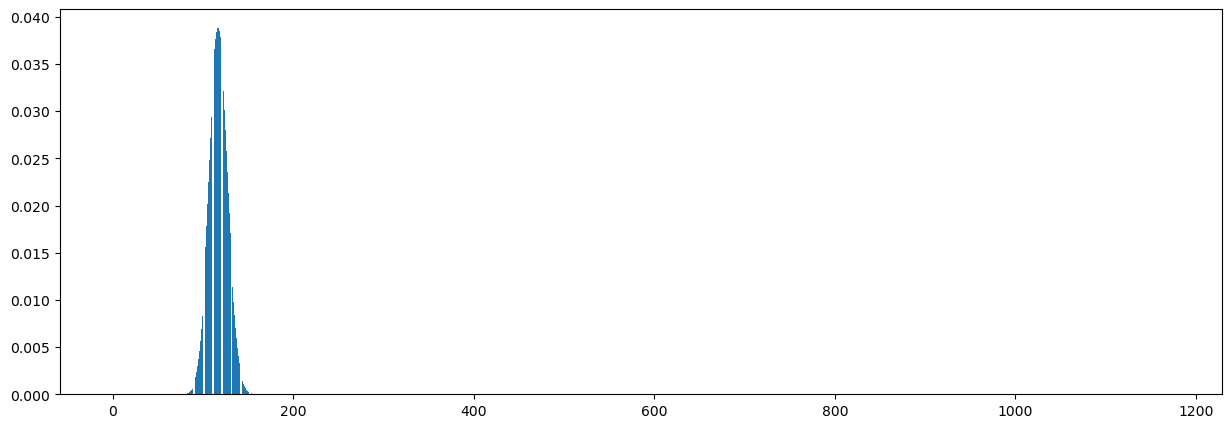

In [30]:
# set the number of trials
n = 1170

# set the success probability based on previous campaigns - 10%
p = 0.1

distr = pd.Series(0)

# calculate the probabilities of successes for all trials
for k in range(0, n+1):
    distr[k] = binom.pmf(k,n,p)

# plot the distribution graph of the obtained probabilities
plt.figure(figsize=[15, 5])
plt.bar(range(0, n+1), distr);

### Conduct an analysis for the second additional task for the marketing department with the following conditions:

The marketing department sends push notifications to customers in the mobile application. Customers may open or not open these notifications. It is known that approximately 40% of recipients open the notifications. The department plans to send out 11 million notifications. Using approximation, build an approximate distribution graph and estimate the probability that no more than 399,500 users will open the notification.

Given a large number of users (Bernoulli trials) and a success probability of 40%, it is reasonable to apply the binomial distribution approximation with the normal distribution:

In [31]:
# set the initial data for the probability and number of trials
n = 1000000
p = 0.4

# calculate the data for approximation with a normal distribution
mu = n*p #матожидание
sigma = (n*p*(1-p))**0.5 #стандартное отклонение

# set the normal distribution with the calculated mean and standard deviation
distr = st.norm(mu, sigma) 

# the value for which we want to find the probability
x = 399500

# calculate the probability of getting a value less than x
result = distr.cdf(x)
print(f'The probability that no more than {x} users will open the notifications: {result:.1%}')

Вероятность, что не более 399500 пользователей откроют письма: 15.4%


Considering the obtained data, we can conclude that with a given probability of opening the notifications (40%) and 11 million attempts (the number of planned notifications to be sent), the probability that there will be fewer than 399,500 successes (i.e., this many or fewer users open the notification) is virtually zero.

In [32]:
# Set the initial data for the probability and number of trials
n = 1_000_000
p = 0.4

# calculate the data for approximation with a normal distribution
mu = n*p #Матematical expectation
sigma = (n*p*(1-p))**0.5 #standard deviation

# set the normal distribution with the calculated mean and standard deviation
distr = st.norm(mu, sigma) 

# the value for which we want to find the probability
x = 399500

# calculate the probability of getting a value less than x
result = distr.cdf(x)
print(f'The probability that no more than {x} users will open the notifications: {result:.1%}')


Вероятность, что не более 399500 пользователей откроют письма: 15.4%


**Conclusion**

During the analysis of the data, preliminary processing of the dataset was carried out by converting dates to the correct type and adding necessary columns for subsequent analysis. Duplicates were excluded.

The exploratory analysis did not reveal critical issues regarding the structure of the data: the data is evenly distributed across all considered parameters. Additionally, we calculated that the average trip length was 3071 meters and lasted 18 minutes; the number of users without a subscription exceeds those with a subscription by approximately 15%. There are two peaks in trip lengths—720m and 3000m.

Next, we combined the data into a single table and extracted two datasets for users with and without subscriptions. We calculated monthly revenue per user and found that the total revenue amounted to 3,878,641 rubles. For better comparison, here are the main parameters by key groups of users:

- We earned 1,645,000 rubles from users with a subscription over a year compared to 2,234,000 rubles from users without a subscription.
- On average, one user with a subscription generates 196 rubles per month versus 223 rubles for a non-subscriber.

Based on the obtained and calculated data, we tested three proposed hypotheses:

After testing **the first hypothesis** that subscribers spend more time in rides, we can reject the null hypothesis about equal mean values of time spent by both groups. Therefore, it is concluded that users with subscriptions indeed spend more time riding.

Upon testing **the second hypothesis**, which states that on average users with a subscription travel 3130 meters per ride, we cannot exclude this version. It is quite possible that users with subscriptions travel approximately or close to this distance in one ride.

After testing the **third hypothesis** stating that monthly revenue from subscribers exceeds revenue from non-subscribers, we can reject the null hypothesis and conclude that alternative hypotheses about higher average revenue for paying users cannot be rejected.

Regarding the **fourth hypothesis**, it is recommended to use a two-sample t-test for dependent samples to assess its effectiveness, using `st.ttest_rel()` with the greater alternative hypothesis (one-tailed test).

**Upon testing** the hypothesis about longer rides, we cannot assume greater revenue from subscribers because extended ride time does not guarantee increased revenue (cost per minute and trip start cost must be considered). We confirmed that paying subscribers travel no more than an optimal distance for one ride, which means there is no additional wear-and-tear with higher revenue due to subscription fees. Therefore, increasing the number of subscribers benefits the service. The third hypothesis also confirms that paying subscribers on average can be more profitable users from a revenue standpoint.

Additionally, two extra tasks were considered for the marketing department:
- With obtained data and constructed graph, it is concluded that at an individual success probability of 10% to achieve a gain of 100 new users with a failure probability of approximately 5%, one needs to distribute a minimum of 1171 promo codes.
- Given the high probability of individual success (40%) and 11 million planned notifications, the probability that fewer than 399,500 notifications are opened (that is, this many or fewer users will open it) is virtually zero.

This comprehensive analysis provides valuable insights into user behavior and subscription benefits for future marketing strategies.